In [1]:
import os
from os import path
import random
import cv2
from tqdm import tqdm
import pickle

import numpy as np
import pandas as pd
import matplotlib as plt
from matplotlib import pyplot
from matplotlib.image import imread
from sklearn.neighbors import NearestNeighbors
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch.autograd import Variable


# https://hackernoon.com/how-to-autoencode-your-pok%C3%A9mon-6b0f5c7b7d97
# https://www.cs.toronto.edu/~lczhang/360/lec/w05/autoencoder.html
# https://www.youtube.com/watch?v=IKOHHItzukk&list=PLZbbT5o_s2xrfNyHZsM6ufI0iZENK9xgG&index=18
# https://discuss.pytorch.org/t/layer-reshape-issue/18938/4
# https://towardsdatascience.com/find-similar-images-using-autoencoders-315f374029ea
# https://towardsdatascience.com/build-a-simple-image-retrieval-system-with-an-autoencoder-673a262b7921

In [2]:
FOLDER = '/Pictures/'
IMG_SIZE = 50
CURRENT_DIR = path.abspath(path.curdir)
BATCH_SIZE = 16
NUM_EPOCHS = 50
LR = 0.001


img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
files = os.listdir(CURRENT_DIR + FOLDER)
images = []
names = []

for file in tqdm(files):
    
    name = file.split('.')[0]
    names.append(name)

    image = cv2.imread(os.path.join(CURRENT_DIR + FOLDER,file))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(IMG_SIZE,IMG_SIZE))
    images.append(image)

# train_set = [(images[i], names[i]) for i in range(0, len(images))]
train_set = pd.DataFrame({'image':images,'name':names}).sample(frac=1).reset_index(drop=True)

100%|██████████| 890/890 [00:02<00:00, 413.89it/s]


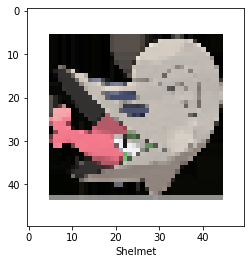

In [4]:
sample = train_set.sample(n=1)
pyplot.imshow(sample['image'].values[0])
label = sample['name'].values[0]
pyplot.xlabel(label)

pyplot.show()

In [5]:
class ImageDataset(Dataset):

    def __init__(self,data,transform=img_transform):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self,index):
        if torch.is_tensor(index):
            index = index.tolist()

        item = self.data.iloc[index]
        name = item[1]
        image = item[0]/255
        
        if self.transform:
            sample = self.transform(image)
        
        return np.moveaxis(image,-1,0), name
    
dataset = ImageDataset(train_set)

In [6]:
dataloader = DataLoader(
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True
    )

In [7]:
sample = next(iter(dataloader))
images, labels = sample
images.shape    

torch.Size([16, 3, 50, 50])

In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.Conv1 = nn.Conv2d(3,16,3)
        self.Conv2 = nn.Conv2d(16,32,3)
        self.Conv3 = nn.Conv2d(32,64,7)

        
        self.pool = nn.MaxPool2d(2,2,return_indices=True)
        

        self.ConvTrans3 = nn.ConvTranspose2d(64,32,7)
        self.ConvTrans2 = nn.ConvTranspose2d(32,16,3)
        self.ConvTrans1 = nn.ConvTranspose2d(16,3,3)
        
        self.unpool = nn.MaxUnpool2d(2,2)
        self.sig = nn.Sigmoid()
        
        

    def forward(self, x):
        
        x = self.Conv1(x)
        x = F.relu(x)
        x, indices1 = self.pool(x)
        x = self.Conv2(x)
        x = F.relu(x)
        x, indices2 = self.pool(x)
        x = self.Conv3(x)
        
        x = self.ConvTrans3(x)
        x = self.unpool(x,indices2)
        x = F.relu(x)
        x = self.ConvTrans2(x)
        x = self.unpool(x,indices1)
        x = F.relu(x)
        x = self.ConvTrans1(x)
        x = self.sig(x)
        
        return x
    
    def encode(self,x):
        
        x = self.Conv1(x)
        x = F.relu(x)
        x, indices1 = self.pool(x)
        x = self.Conv2(x)
        x = F.relu(x)
        x, indices2 = self.pool(x)
        x = self.Conv3(x)
        
        return x

In [9]:
model = Autoencoder().float()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR,
                             weight_decay=1e-5)

In [10]:
sample = next(iter(dataloader))
images, labels = sample
images = images.float()
print(images.shape)
with torch.no_grad():
    x = model(images)
print(x.shape)

torch.Size([16, 3, 50, 50])
torch.Size([16, 3, 50, 50])


In [172]:
def train(model, num_epochs, criterion, optimizer, dataloader):
    torch.manual_seed(42)

    outputs = []
    for epoch in range(num_epochs):
        for data in dataloader:
            img, _ = data
            recon = model(img.float())
            loss = criterion(recon.double(), img.double())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f'Epoch:{epoch+1}, Loss:{float(loss)}')
        outputs.append((epoch, img, recon),)
    return outputs

In [ ]:
test = train(model, NUM_EPOCHS, criterion, optimizer, dataloader)

Epoch:1, Loss:0.011547254945993183
Epoch:2, Loss:0.007063754833264752
Epoch:3, Loss:0.004198912506955501
Epoch:4, Loss:0.0053281543659809616
Epoch:5, Loss:0.003255735721928777
Epoch:6, Loss:0.003863556959730855
Epoch:7, Loss:0.001748583464152377
Epoch:8, Loss:0.004776062272919696
Epoch:9, Loss:0.0014154485390323926
Epoch:10, Loss:0.000863575320897127
Epoch:11, Loss:0.0008726591631533387
Epoch:12, Loss:0.0008307609193632247
Epoch:13, Loss:0.000646553723545845
Epoch:14, Loss:0.0007205604391243201
Epoch:15, Loss:0.0006291322866767424
Epoch:16, Loss:0.0013303674169951203
Epoch:17, Loss:0.0005740408285407286
Epoch:18, Loss:0.0146304818973406
Epoch:19, Loss:0.003112459470223244
Epoch:20, Loss:0.009119992959255177
Epoch:21, Loss:0.002141241548182268
Epoch:22, Loss:0.0015917876207679365
Epoch:23, Loss:0.003623389002605154
Epoch:24, Loss:0.001275201758914124
Epoch:25, Loss:0.0012325337533490124
Epoch:26, Loss:0.0019006807085601913


In [126]:
torch.save(model.state_dict(),CURRENT_DIR + 'PokeModel')

In [11]:
model = Autoencoder().float()
model.load_state_dict(torch.load(CURRENT_DIR + 'PokeModel'))
model.eval()

Autoencoder(
  (Conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (Conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (Conv3): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ConvTrans3): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
  (ConvTrans2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (ConvTrans1): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(1, 1))
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (sig): Sigmoid()
)

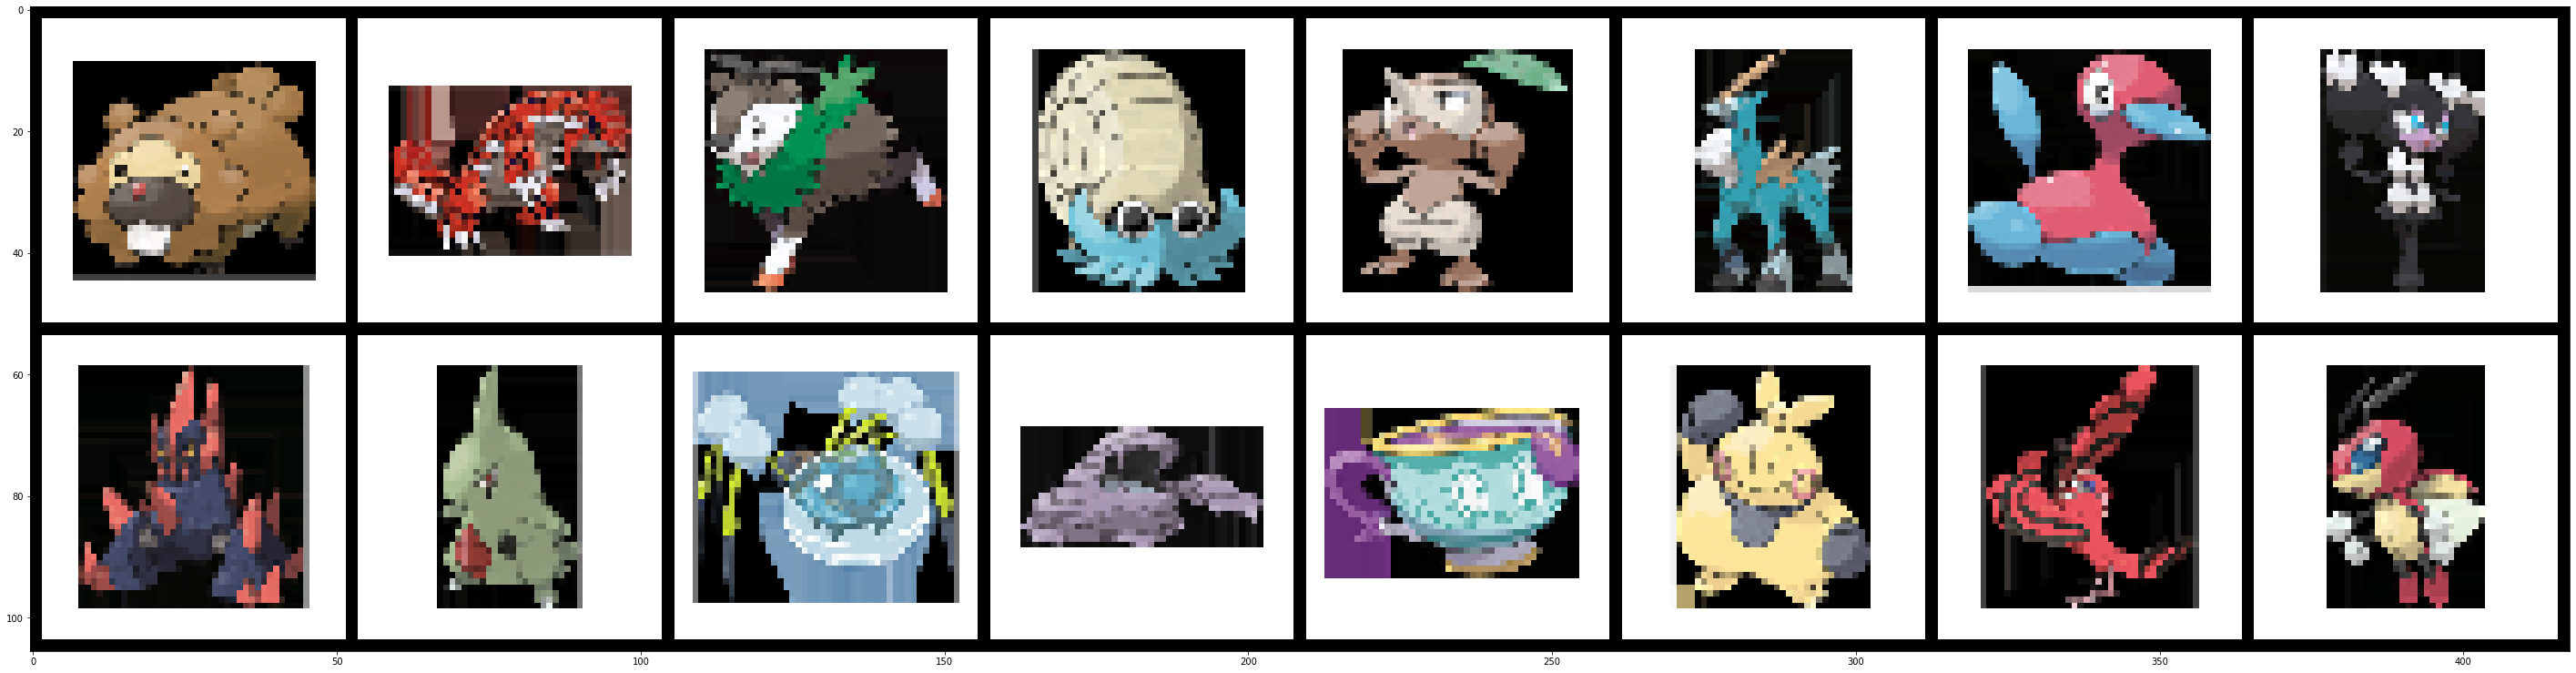

In [12]:
sample = next(iter(dataloader))
images, labels = sample
grid = torchvision.utils.make_grid(images,nrow=8)
plt.figure(figsize=(50,50))
plt.imshow(grid.numpy().transpose(1,2,0))

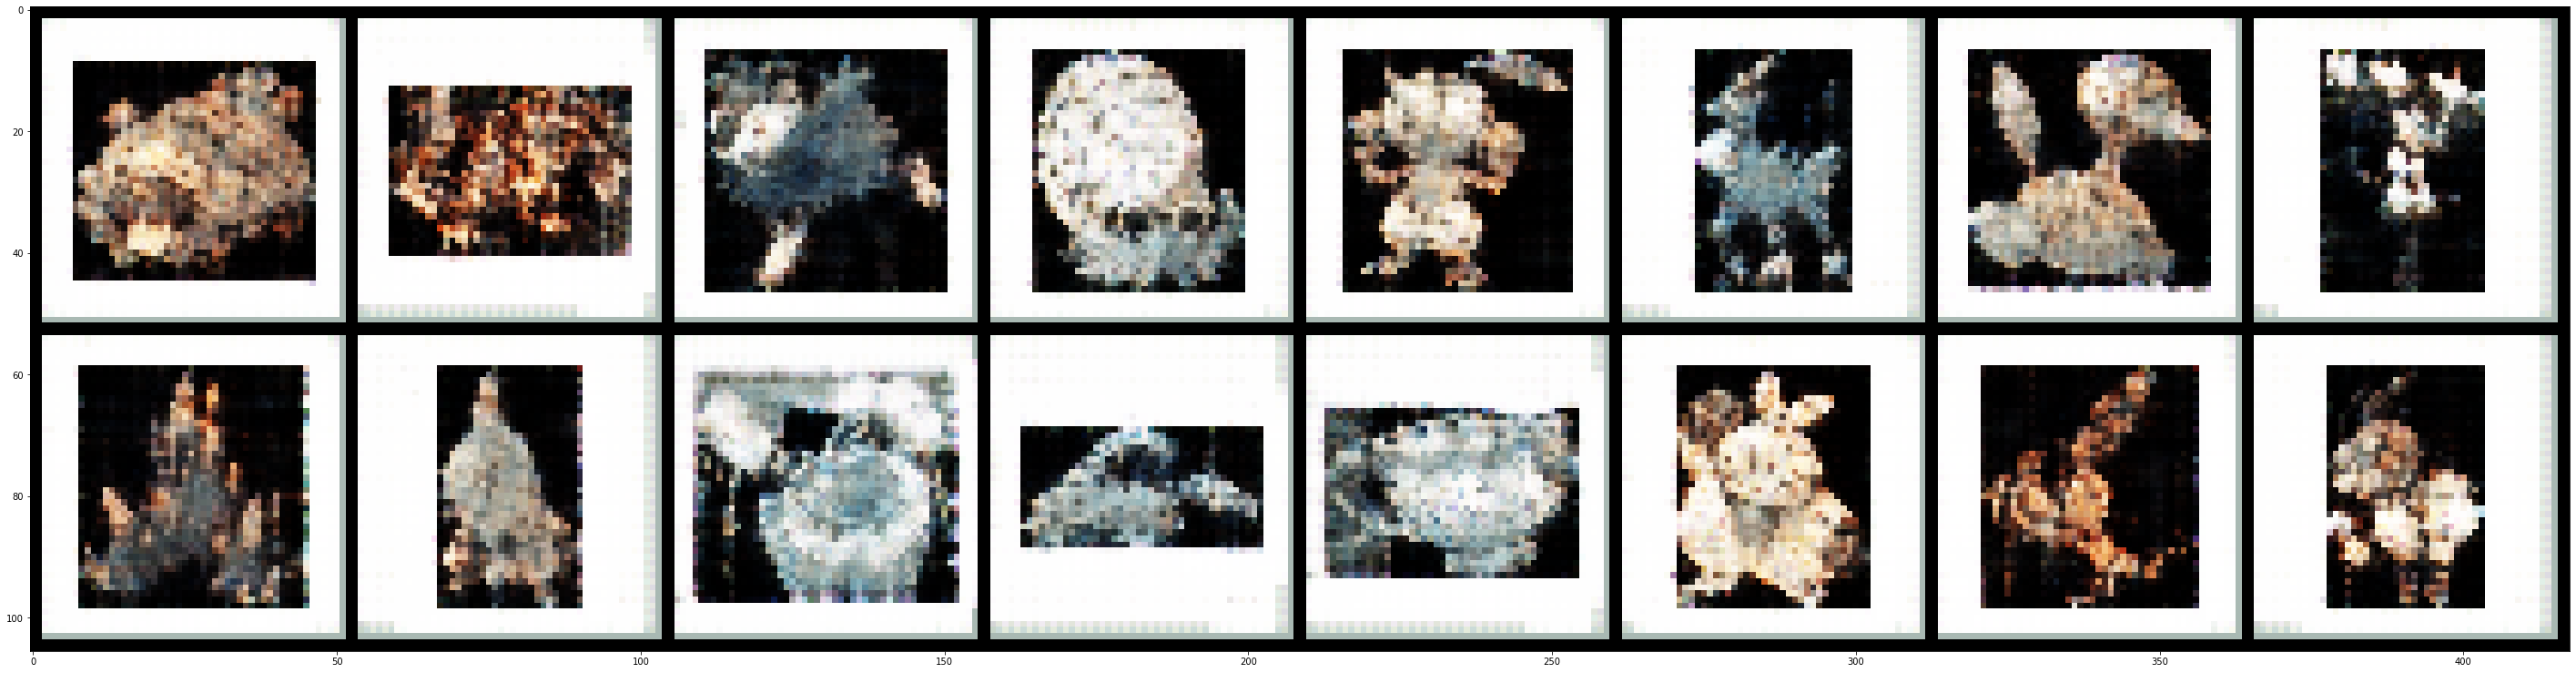

In [14]:
with torch.no_grad():
    test_images = model(images.float())
test_grid = torchvision.utils.make_grid(test_images,nrow=8)
plt.figure(figsize=(50,50))
plt.imshow(test_grid.numpy().transpose(1,2,0))

In [16]:
dataloader = DataLoader(
    dataset, 
    batch_size=train_set.shape[0],
    shuffle=True
    )

og_images,labels = next(iter(dataloader))


with torch.no_grad():
    encodings = model.encode(og_images.float())
encodings = encodings.reshape((-1, np.prod(1600)))
encodings = encodings.numpy()
# og_images = og_images.numpy().transpose(3,1,2,0)





In [17]:
encodings.shape

(890, 1600)

In [18]:
knn = NearestNeighbors(n_neighbors=5, metric="cosine")
knn.fit(np.asarray(encodings))

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [25]:
distances, indices = knn.kneighbors(encodings[306].reshape(1,-1))

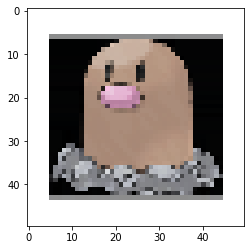

In [24]:
plt.imshow(og_images[306].permute(1,2,0))

In [26]:
closest_images = og_images[indices]

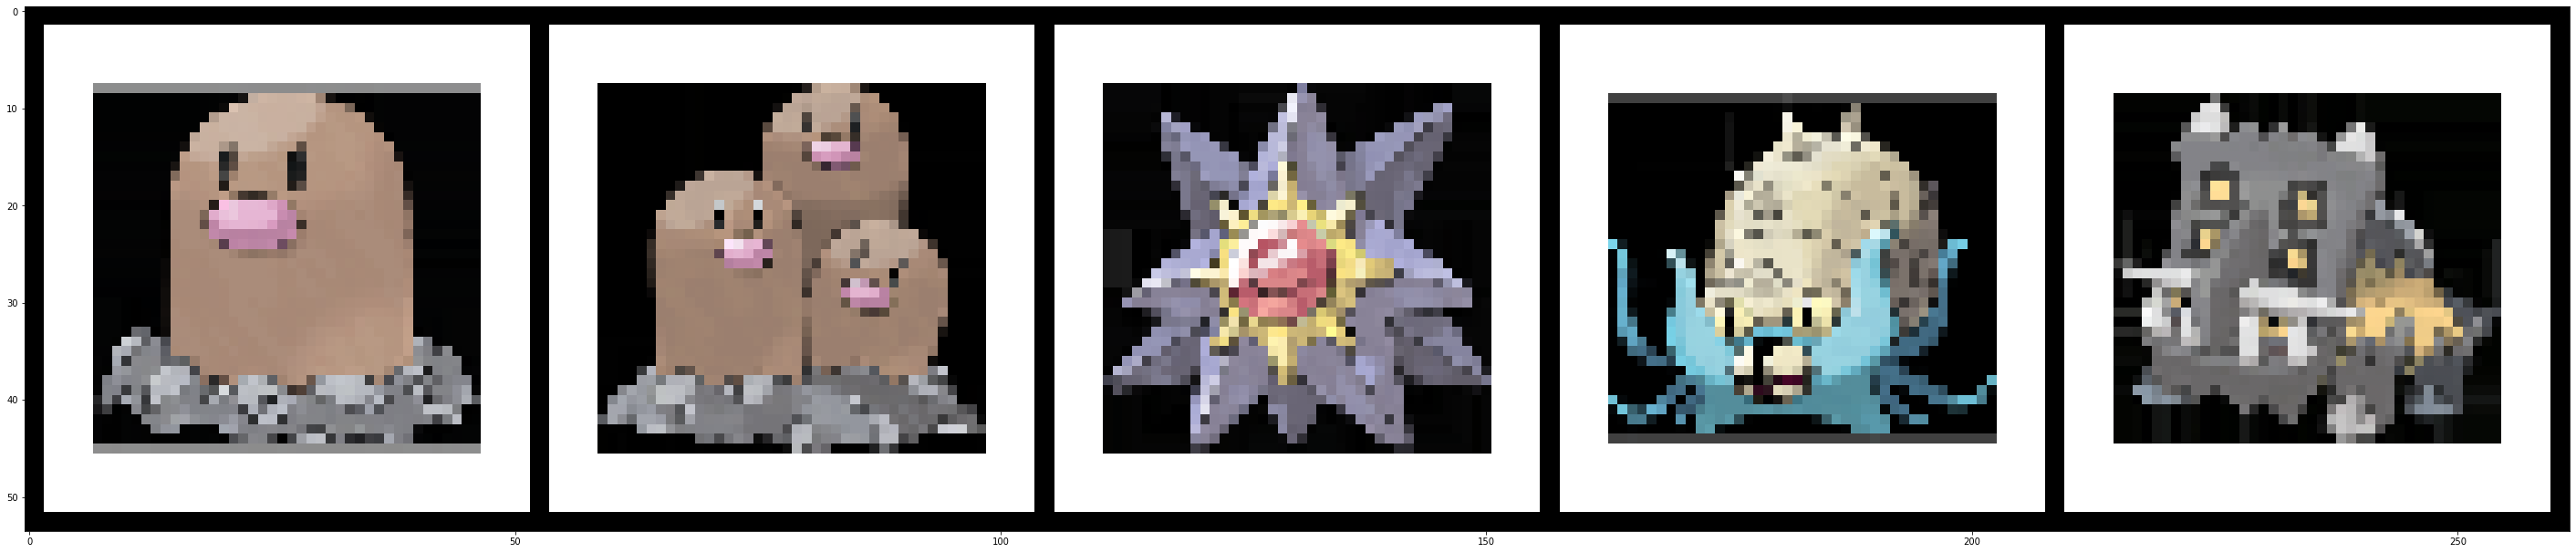

In [27]:
closest_grid = torchvision.utils.make_grid(closest_images,nrow=5)
plt.figure(figsize=(50,50))
plt.imshow(closest_grid.numpy().transpose(1,2,0))

In [23]:
for i,label in enumerate(labels):
    if label=='Diglett':
        print(f'{label} is {i}')

Diglett is 306
